In [19]:
!pip install vizdoom

In [20]:
!git clone https://github.com/Farama-Foundation/ViZDoom.git

fatal: destination path 'ViZDoom' already exists and is not an empty directory.


In [21]:
from vizdoom import *
import random
import time
import numpy as np

In [22]:
!pip install gym

In [23]:
pip install opencv-python-headless

Note: you may need to restart the kernel to use updated packages.


In [24]:
import gymnasium
from gymnasium.spaces import Discrete, Box
import cv2

In [ ]:
# Setting up vizdoom as a subclass of gymnasium
class VizDoomGym(gymnasium.Env): 
    # Function that is called when we start the env
    def __init__(self, render=False): 
        # Inherit from Env
        super().__init__()
        # Setup the game 
        self.game = DoomGame()
        self.game.load_config('ViZDoom/scenarios/defend_the_center.cfg')
        
        # Render frame logic
        if render == False: 
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)
        
        # Start the game 
        self.game.init()
        
        # Create the action space and observation space
        self.observation_space = Box(low=0, high=255, shape=(100,160,1), dtype=np.uint8) 
        self.action_space = Discrete(3)
        
    # This is how we take a step in the environment
    def step(self, action):
        # Specify action and take step 
        actions = np.identity(3)
        reward = self.game.make_action(actions[action], 4) 
        
        # Get all the other stuff we need to retun 
        if self.game.get_state(): 
            state = self.game.get_state().screen_buffer
            state = self.grayscale(state)
            ammo = self.game.get_state().game_variables[0]
            info = ammo
        else: 
            state = np.zeros(self.observation_space.shape)
            info = 0 
        
        info = {"info":info}
        done = self.game.is_episode_finished()
        truncated = False
        
        return state, reward, done, truncated, info 
    
    # Define how to render the game or environment 
    def render(self): 
        pass
    
    # What happens when we start a new game 
    def reset(self, *, seed=None, options=None): 
        self.game.new_episode()
        state = self.game.get_state().screen_buffer
        return self.grayscale(state) , {}
    
    # Grayscale the game frame and resize it 
    def grayscale(self, observation):
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (160,100), interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize, (100,160,1))
        return state
    
    # Call to close down the game
    def close(self): 
        self.game.close()

In [26]:
pip install stable-baselines3[extra]


Note: you may need to restart the kernel to use updated packages.


In [ ]:
from stable_baselines3.common import env_checker
env = VizDoomGym(render=True)
env_checker.check_env(env)
#checks if given env works correctly according to gymnasium 

In [28]:
state,info = env.reset()
env.close()

In [29]:
!pip install matplotlib

In [30]:
from matplotlib import pyplot as plt


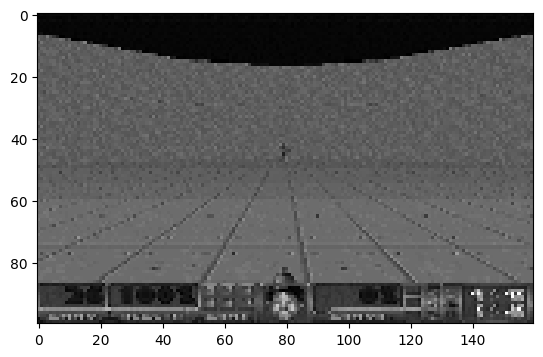

In [ ]:
plt.imshow(state.squeeze(), cmap='gray')
#shows grayscale img which we pass into the neural network

In [32]:
!pip install torch torchvision torchaudio

In [33]:
import os
from stable_baselines3.common.callbacks import BaseCallback

In [ ]:
#setting up callback to review the model progress
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
        return True

In [ ]:
!pip install tensorboard

In [111]:
CHECKPOINT_DIR = './training/training_PPO'
LOG_DIR = './logs/logs_PPO'
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [ ]:
from stable_baselines3 import PPO
env = VizDoomGym()
#model given in tutorial which is based on PPO algorithm
model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.0001, n_steps=4096)
model.learn(total_timesteps=100000, callback=callback)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to ./logs/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 78.5     |
|    ep_rew_mean     | 0.212    |
| time/              |          |
|    fps             | 329      |
|    iterations      | 1        |
|    time_elapsed    | 12       |
|    total_timesteps | 4096     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 80.7        |
|    ep_rew_mean          | 0.28        |
| time/                   |             |
|    fps                  | 139         |
|    iterations           | 2           |
|    time_elapsed         | 58          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.006210498 |
|    clip_fraction        | 0.0266     

In [70]:
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

In [ ]:
model = PPO.load('./training/training_PPO/best_model_100000')

In [ ]:
env = VizDoomGym(render=True)
#env = Monitor(env)
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=10)
env.close()

In [ ]:
mean_reward
#avg reward obtained from above model

np.float64(15.2)

In [ ]:
env = VizDoomGym(render=True)
for episode in range(1,6): 
    obs, _ = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, truncated, info = env.step(action)
        time.sleep(0.05)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))
    time.sleep(1)
env.close()
#viewing the results of the best model i.e 100000 steps

Total Reward for episode 0 is 14.0
Total Reward for episode 1 is 13.0
Total Reward for episode 2 is 9.0
Total Reward for episode 3 is 11.0
Total Reward for episode 4 is 15.0


In [103]:
CHECKPOINT_DIR1 = './training/training_A2C'
LOG_DIR1 = './logs/logs_A2C'
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR1)

In [ ]:
from stable_baselines3 import A2C
env = VizDoomGym()
#better model than before which implements adv actor critic algorithm 
model = A2C("CnnPolicy", env, n_steps=12, tensorboard_log=LOG_DIR1, learning_rate=0.0007)
model.learn(total_timesteps=100000, callback=callback)

In [105]:
model = A2C.load('./training/training_A2C/best_model_100000')
env = VizDoomGym(render=True)
#env = Monitor(env)
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=10)
env.close()

In [107]:
mean_reward

np.float64(16.7)

In [ ]:
#similar evaluation as before
env = VizDoomGym(render=True)
for episode in range(1,6): 
    obs, _ = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, truncated, info = env.step(action)
        time.sleep(0.1)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))
    time.sleep(1)
env.close()

Total Reward for episode 1 is 17.0
Total Reward for episode 2 is 16.0
Total Reward for episode 3 is 20.0
Total Reward for episode 4 is 18.0
Total Reward for episode 5 is 22.0
